In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Feature Selection

In [3]:
# Load your dataset
df = pd.read_csv("dataset_0222.csv")# Ensure this CSV contains 'close_pctc' and feature columns

to_drop = ['date','ticker_id','sector']
df = df.drop(to_drop, axis=1)

In [4]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'dividends', 'vix',
       'eps_estimate', 'reported_eps', 'surprise_', 'earnings_date_flag',
       'pe_ratio', '1_mo_int', '6_mo_int', '1_yr_int', '10_yr_int',
       'sp500_open', 'sp500_high', 'sp500_low', 'sp500_price', 'sp500_volume',
       'open_close', 'high_low', 'high_open_low', 'mkt_returns', 'sp500_oc',
       'sp500_lh', 'sp500_loh', '50_day_avg_sp500', '150_day_avg_sp500',
       '50_day_avg_sp500_relative', '150_day_avg_sp500_relative',
       'sp500_bull_bear', 'sp500_bb_diff', 'rolling_beta', 'ln_volume',
       'beta_vol_interaction', 'beta_close', 'beta_close_relative', 'ema_fast',
       'ema_slow', 'trend_macd', 'macd_sig_line', 'macd_relative_close',
       'macd_sig_line_relative_close', 'momentum_rsi', 'momentum_rsi_relative',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbm_relative', 'volatility_bbh_relative',
       'volatility_bbl_relative', 'volatility_width_relative',
    

In [5]:
df.shape

(78156, 89)

In [6]:
# Define features and target
target = "close_pctc"
features = [col for col in df.columns if col != target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# LightGBM parameters
params = {
    "objective": "regression",
    "metric": "rmse",  # metric 
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "verbose": -1,
    "seed": 42  
}

# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data,free_raw_data=False)

# Train model with evaluation metric
model = lgb.train(
    params=params,  #  naming the argument
    train_set=train_data,  
    valid_sets=[valid_data],
    valid_names=["valid"],
    # early_stopping_rounds=50,
    # verbose_eval=50
)

In [7]:
print(type(train_data), type(valid_data))
# Output should be: <class 'lightgbm.basic.Dataset'> <class 'lightgbm.basic.Dataset'>

<class 'lightgbm.basic.Dataset'> <class 'lightgbm.basic.Dataset'>


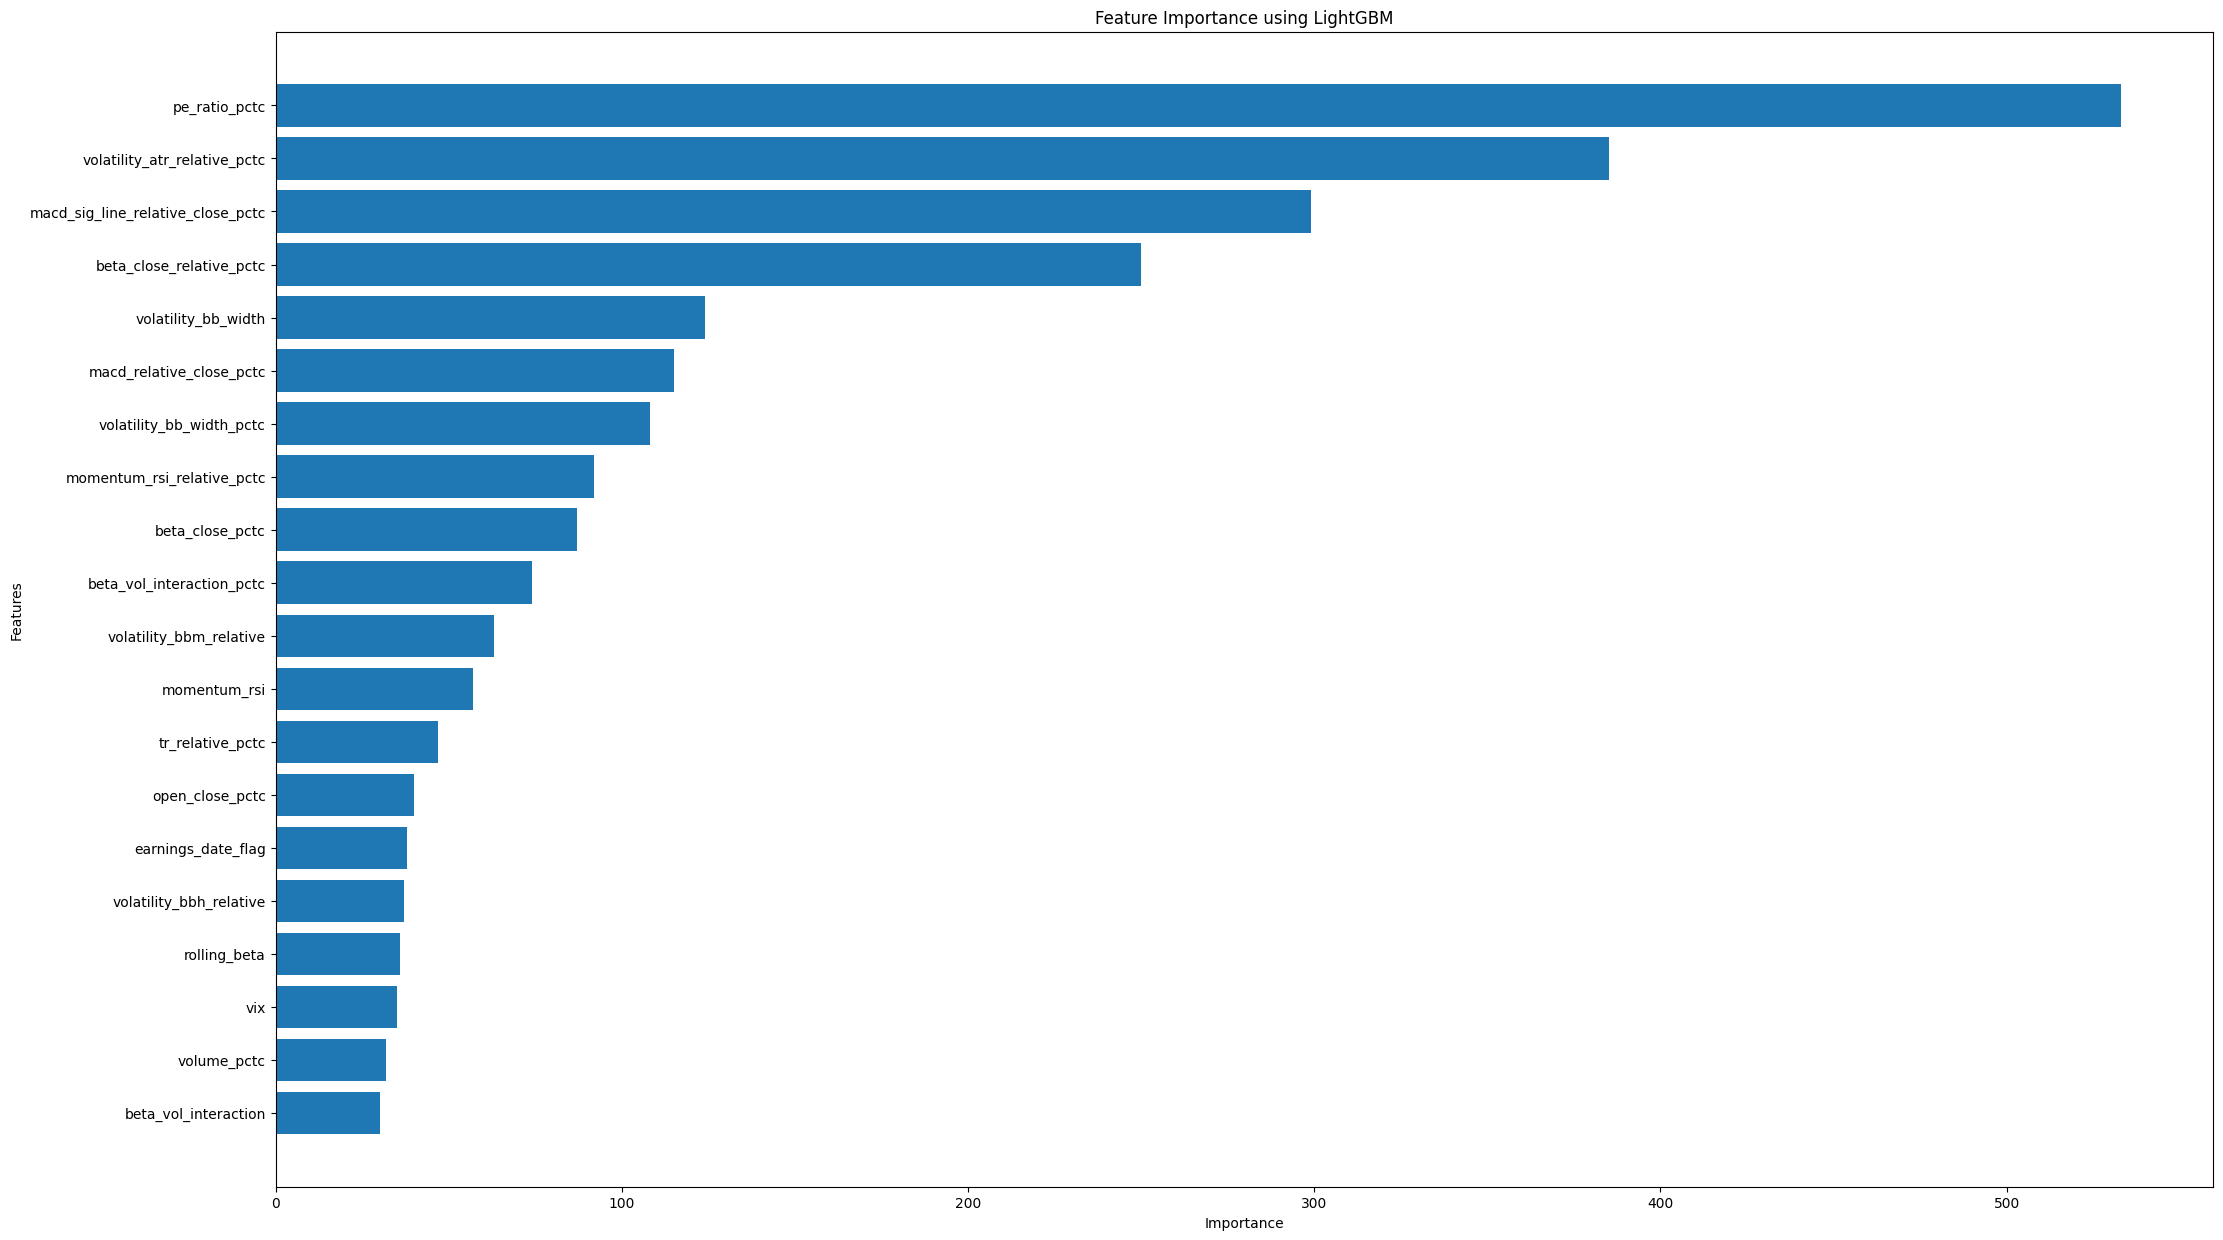

In [8]:
# Get feature importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': model.feature_importance()})
feature_importance = feature_importance.sort_values(by="Importance", ascending=True).tail(20)

# Plot feature importance
plt.figure(figsize=(25, 15))
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance using LightGBM")
plt.show()

In [9]:
pd.set_option('display.max_rows',60000)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_colwidth',200)
pd.options.display.float_format = '{:,.4f}'.format

feature_importance[feature_importance.Importance >= 30].sort_values(by='Importance', ascending=False)

,Feature,Importance
77,pe_ratio_pctc,533
71,volatility_atr_relative_pctc,385
61,macd_sig_line_relative_close_pctc,299
76,beta_close_relative_pctc,250
54,volatility_bb_width,124
60,macd_relative_close_pctc,115
63,volatility_bb_width_pctc,108
62,momentum_rsi_relative_pctc,92
75,beta_close_pctc,87
74,beta_vol_interaction_pctc,74


In [10]:
# Select top features (e.g., top 20)
#top_features = feature_importance["Feature"][:20].tolist()
top_features = feature_importance.nlargest(20, "Importance")["Feature"].tolist()
# Feature importance
#feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model.feature_importance()})
top_features

['pe_ratio_pctc',
 'volatility_atr_relative_pctc',
 'macd_sig_line_relative_close_pctc',
 'beta_close_relative_pctc',
 'volatility_bb_width',
 'macd_relative_close_pctc',
 'volatility_bb_width_pctc',
 'momentum_rsi_relative_pctc',
 'beta_close_pctc',
 'beta_vol_interaction_pctc',
 'volatility_bbm_relative',
 'momentum_rsi',
 'tr_relative_pctc',
 'open_close_pctc',
 'earnings_date_flag',
 'volatility_bbh_relative',
 'rolling_beta',
 'vix',
 'volume_pctc',
 'beta_vol_interaction']

In [11]:
set(top_features) - set( ['volatility_atr_relative_pctc',
       'macd_sig_line_relative_close_pctc', 'macd_relative_close_pctc',
       'beta_close_relative_pctc', 'tr_relative_pctc', 'open_close_pctc',
       'volatility_bbm_relative', 'volatility_bbh_relative', 'momentum_rsi',
       'momentum_rsi_relative_pctc', 'pe_ratio_pctc', 'volatility_bb_width',
       'beta_vol_interaction_pctc', 'rolling_beta',
       'beta_close_pctc', 'beta_vol_interaction', 'vix', 'volume_pctc'])

{'earnings_date_flag', 'volatility_bb_width_pctc'}

In [12]:
# Train a new model with selected features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# Create new dataset with free_raw_data=False
train_data_selected = lgb.Dataset(X_train_selected, label=y_train, free_raw_data=False)
valid_data_selected = lgb.Dataset(X_test_selected, label=y_test, reference=train_data_selected, free_raw_data=False)

# Train model on selected features
model_selected = lgb.train(params, train_data_selected, valid_sets=[valid_data_selected],)
#early_stopping_rounds=50, verbose_eval=50)

# Evaluate performance
y_pred = model_selected.predict(X_test_selected)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE after feature selection: {rmse}")

RMSE after feature selection: 0.0020834006429060604


In [13]:
import lightgbm as lgb
print(lgb.__version__)  # Should be 3.x or later


4.5.0


In [14]:
df_1 = pd.read_csv("dataset_0222.csv")
new_stock_list = list(df_1['ticker_id'].unique())
ticker_data_dict = {ticker: df_1[df_1['ticker_id']==ticker].copy() for ticker in new_stock_list}
non_float_columns = df_1.select_dtypes(exclude=['float64', 'float32']).columns
top_features_1 = top_features + ['close_pctc']

In [15]:
df_1.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'dividends',
       'ticker_id', 'sector', 'vix', 'eps_estimate', 'reported_eps',
       'surprise_', 'earnings_date_flag', 'pe_ratio', '1_mo_int', '6_mo_int',
       '1_yr_int', '10_yr_int', 'sp500_open', 'sp500_high', 'sp500_low',
       'sp500_price', 'sp500_volume', 'open_close', 'high_low',
       'high_open_low', 'mkt_returns', 'sp500_oc', 'sp500_lh', 'sp500_loh',
       '50_day_avg_sp500', '150_day_avg_sp500', '50_day_avg_sp500_relative',
       '150_day_avg_sp500_relative', 'sp500_bull_bear', 'sp500_bb_diff',
       'rolling_beta', 'ln_volume', 'beta_vol_interaction', 'beta_close',
       'beta_close_relative', 'ema_fast', 'ema_slow', 'trend_macd',
       'macd_sig_line', 'macd_relative_close', 'macd_sig_line_relative_close',
       'momentum_rsi', 'momentum_rsi_relative', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbm_relative',
       'volatility_bbh_relative', 'volatility_bbl_relative',
  

In [16]:
corr_df = []
for i, ticker in enumerate(new_stock_list):
    dd = ticker_data_dict[ticker][top_features_1].corr()[['close_pctc']]
    dd.columns = [ticker]
    corr_df.append(dd)

corr_df_1 = pd.concat(corr_df,axis=1)

In [17]:
corr_df_1.sort_values(by='T', ascending=False).head(21)

,T,VZ,GOOG,META,NFLX,DIS,MCD,AZO,AMZN,HD,TSLA,BKNG,CTRA,XOM,CVX,EOG,OKE,COP,PGR,CB,BRK-B,JPM,BAC,GS,LLY,UNH,BSX,SYK,ISRG,HCA,IBM,TYL,AAPL,MSFT,NVDA,CRM
close_pctc,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
volatility_atr_relative_pctc,0.9981,0.9981,0.9987,0.9989,0.9986,0.9983,0.9979,0.9976,0.9985,0.9983,0.9982,0.9986,0.9979,0.9985,0.9984,0.9982,0.9913,0.9983,0.9980,0.9977,0.9984,0.9984,0.9984,0.9983,0.9981,0.9981,0.9979,0.9983,0.9983,0.9978,0.9986,0.9978,0.9984,0.9984,0.9984,0.9984
macd_sig_line_relative_close_pctc,0.9965,0.9965,0.9969,0.9965,0.9950,0.9960,0.9963,0.9963,0.9964,0.9963,0.9948,0.9958,0.9965,0.9950,0.9950,0.9936,0.9790,0.9927,0.9973,0.9958,0.9965,0.9960,0.9953,0.9955,0.9968,0.9970,0.9964,0.9962,0.9962,0.9951,0.9955,0.9967,0.9965,0.9975,0.9961,0.9968
macd_relative_close_pctc,0.9941,0.9941,0.9947,0.9939,0.9923,0.9938,0.9938,0.9937,0.9938,0.9937,0.9919,0.9932,0.9939,0.9924,0.9921,0.9905,0.9699,0.9896,0.9951,0.9933,0.9943,0.9938,0.9929,0.9931,0.9945,0.9944,0.9940,0.9937,0.9935,0.9918,0.9931,0.9942,0.9944,0.9956,0.9938,0.9944
beta_close_relative_pctc,0.9814,0.9961,0.9994,0.9999,0.9999,0.9998,0.9999,1.0000,0.9992,0.9999,0.9937,1.0000,0.9811,0.9988,0.9996,0.9989,0.9966,0.9984,0.9984,0.9998,0.9999,0.9997,0.9925,0.9999,0.9997,0.9999,0.9965,0.9999,0.9999,0.9996,0.9997,0.9999,0.9989,0.9998,0.1961,0.9999
tr_relative_pctc,0.8428,0.8276,0.8674,0.8753,0.8528,0.8480,0.8427,0.8184,0.8610,0.8704,0.8364,0.8672,0.8144,0.8571,0.8737,0.8367,0.8420,0.8691,0.8217,0.8249,0.8628,0.8577,0.8594,0.8628,0.7801,0.8302,0.8068,0.8483,0.8484,0.8277,0.8605,0.7748,0.8596,0.8643,0.8569,0.8520
open_close_pctc,0.8402,0.8053,0.8326,0.8614,0.8306,0.8355,0.8144,0.7712,0.8243,0.8123,0.8185,0.8409,0.7631,0.8265,0.8387,0.8262,0.8099,0.8231,0.7825,0.8021,0.8363,0.8547,0.8479,0.8354,0.8345,0.8137,0.8099,0.8188,0.8299,0.8148,0.8569,0.7803,0.8330,0.8108,0.8015,0.8371
volatility_bbm_relative,0.3703,0.3743,0.3489,0.3456,0.3562,0.3671,0.3589,0.3242,0.3559,0.3559,0.3080,0.3395,0.3605,0.3558,0.3437,0.3550,0.3587,0.3393,0.3329,0.3666,0.3547,0.3500,0.3566,0.3484,0.2743,0.3345,0.3635,0.3565,0.3518,0.3336,0.3618,0.3571,0.3304,0.3285,0.2278,0.3480
volatility_bbh_relative,0.2789,0.3030,0.2709,0.2539,0.2840,0.2775,0.2388,0.2504,0.2751,0.2596,0.2220,0.2644,0.2702,0.2799,0.2426,0.2819,0.2588,0.2543,0.2937,0.2789,0.2913,0.2737,0.2794,0.2950,0.1744,0.2634,0.2749,0.2674,0.2714,0.2399,0.2820,0.2677,0.2678,0.2568,0.1654,0.2722
momentum_rsi,0.2256,0.2405,0.2275,0.2290,0.2419,0.2471,0.2225,0.2283,0.2307,0.2203,0.2835,0.2171,0.2224,0.2406,0.2159,0.2356,0.2189,0.2253,0.2156,0.2263,0.2246,0.2138,0.2332,0.2309,0.2460,0.1998,0.2279,0.2135,0.2310,0.2287,0.2381,0.2323,0.2336,0.2143,0.2491,0.2237


In [18]:
testing_1 = list(corr_df_1.sort_values(by='T', ascending=False).head(21).index)
testing_1 = testing_1 + list(non_float_columns) + ['close'] #'dividends'

to_go = df_1[testing_1].copy()

#to_go.to_csv('dataset_250222_run.csv',index=False)

In [19]:
to_go.head()

,close_pctc,volatility_atr_relative_pctc,macd_sig_line_relative_close_pctc,macd_relative_close_pctc,beta_close_relative_pctc,tr_relative_pctc,open_close_pctc,volatility_bbm_relative,volatility_bbh_relative,momentum_rsi,momentum_rsi_relative_pctc,pe_ratio_pctc,volatility_bb_width,earnings_date_flag,beta_vol_interaction_pctc,rolling_beta,beta_close_pctc,beta_vol_interaction,vix,volume_pctc,volatility_bb_width_pctc,date,ticker_id,sector,close
0,0.0019,0.0015,0.0023,0.0023,0.0025,-0.0019,0.0007,0.1286,-0.0993,54.8287,0.0504,0.0019,-0.0263,0.0000,0.1420,0.2859,-0.0353,0.9313,11.3900,0.6498,0.0200,2016-08-05,T,Communication Services,17.3446
1,-0.0053,-0.0057,-0.0049,-0.0045,-0.0057,-0.0035,-0.0025,0.0277,-0.1918,52.3811,-0.0628,-0.0053,-0.0254,0.0000,-0.0862,0.2912,0.0241,0.8510,11.5000,-0.2848,-0.0314,2016-08-08,T,Communication Services,17.2522
2,0.0035,0.0035,0.0041,0.0040,0.0049,0.0049,-0.0008,0.0745,-0.1307,55.3624,0.0832,0.0035,-0.0237,0.0000,-0.0615,0.2687,-0.0806,0.7987,11.6600,0.0516,-0.0681,2016-08-09,T,Communication Services,17.3124
3,0.0028,0.0032,0.0033,0.0031,0.0028,0.0044,0.0027,0.1105,-0.0933,60.0594,0.1222,0.0028,-0.0235,0.0000,-0.0768,0.2688,-0.0024,0.7374,12.0500,-0.2050,-0.0100,2016-08-10,T,Communication Services,17.3607
4,0.0044,0.0056,0.0048,0.0044,0.0049,0.0049,0.0051,0.1744,-0.0433,54.6981,-0.1273,0.0044,-0.0250,0.0000,-0.0231,0.2606,-0.0347,0.7203,11.6800,0.0210,0.0638,2016-08-11,T,Communication Services,17.4370
